In [25]:
# Kullanacağımız KerasLayer modülünün keras3 ile uyumlu olmamasından dolayı uygun sürümleri kuracağız.
!pip install --upgrade --quiet tensorflow==2.14 keras==2.14 pennylane==0.32


## Veri setinin yüklenmesi


In [2]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')


zip_path = "/content/drive/My Drive/UAV.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("islem basarili!")


Mounted at /content/drive
islem basarili!


## Gerekli kütüphane kurulumları


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

## Veri setinin yüklenmesi ve ön işleme adımları

In [4]:
import os
import shutil


veri_yolu = "/content/dataset/NEW_DATASET/"
filtrelenmis_veri_yolu = "/content/dataset/FILTERED_DATASET/"

if not os.path.exists(filtrelenmis_veri_yolu):
    os.makedirs(filtrelenmis_veri_yolu)

for sinif in os.listdir(veri_yolu):
    sinif_yolu = os.path.join(veri_yolu, sinif)
    if os.path.isdir(sinif_yolu):
        filtrelenmis_sinif_yolu = os.path.join(filtrelenmis_veri_yolu, sinif)
        os.makedirs(filtrelenmis_sinif_yolu, exist_ok=True)

        for dosya in os.listdir(sinif_yolu):
            if dosya.lower().endswith((".png", ".jpg", ".jpeg")):
                shutil.copy(os.path.join(sinif_yolu, dosya), filtrelenmis_sinif_yolu)

dataset = tf.keras.utils.image_dataset_from_directory(
    filtrelenmis_veri_yolu,
    seed=27,
    image_size=(64, 64),
    batch_size=32
)

images = []
labels = []
for image_batch, label_batch in dataset:
    images.extend(image_batch.numpy())
    labels.extend(label_batch.numpy())

images = np.array(images)
labels = np.array(labels)

train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.2, random_state=27
)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=27
)

train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
val_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

def normalize_images(images, labels):
    normalized_images = images / 255.0
    return normalized_images, labels

train_data = train_data.map(normalize_images)
val_data = val_data.map(normalize_images)
test_data = test_data.map(normalize_images)



Found 706 files belonging to 3 classes.


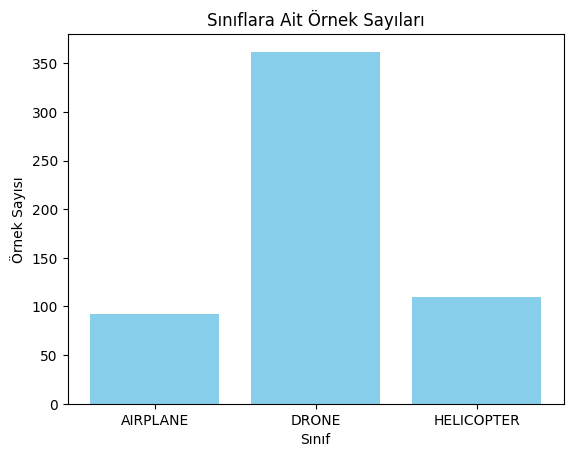

In [5]:
sinif_isimleri = ["AIRPLANE", "DRONE", "HELICOPTER"]
sinif_sayilari = [np.sum(train_labels == sinif) for sinif in range(len(sinif_isimleri))]


plt.bar(sinif_isimleri, sinif_sayilari, color="skyblue")

plt.title("Sınıflara Ait Örnek Sayıları")
plt.xlabel("Sınıf")
plt.ylabel("Örnek Sayısı")

plt.show()

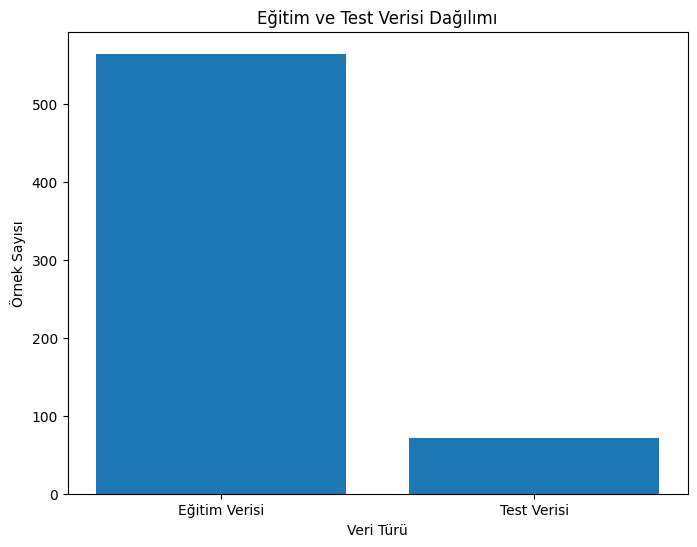

<Figure size 800x400 with 0 Axes>

In [15]:

train_size = len(train_images)
test_size = len(test_images)

plt.figure(figsize=(8, 6))
plt.bar(["Eğitim Verisi", "Test Verisi"], [train_size, test_size])

plt.title("Eğitim ve Test Verisi Dağılımı")
plt.xlabel("Veri Türü")
plt.ylabel("Örnek Sayısı")
plt.figure(figsize=(8,4))

plt.show()

## Kuantum devresinin hazırlanması


In [16]:
qubits = 4
layers_sayisi = 2
dev = qml.device("default.qubit", wires=qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):

# bu çalışmada dönüş kapıları manuel olarak eklendiği için tensorflow kütüphanesine ait olan tf.unstack modülü kullanıldı.
# alternatif olarak Pennylane ait qml.AngleEmbedding modülü eklenebilir.Bu modül manuel işleme gerek kalmadan verileri doğrudan qubitlere yerleştirir.
    angles = tf.unstack(inputs, axis=1)
    for i in range(len(angles)):
      angle = angles[i]
      qml.RZ(angle, wires=i)
      qml.RX(angle, wires=i)

# qubitlerin dolaşık hale getirilmesi için Hadamard ve CNOt kapıların ekleyeceğiziz.
    for i in range(qubits):
      qml.Hadamard(wires=i)

      qml.CNOT(wires=[0, 1])
      qml.CNOT(wires=[1, 2])
      qml.CNOT(wires=[2, 3])

# her katmanda qubitler üzerinde parametrik dönüş kapıları ile işlem gerçekleştiriliyor.
# Dönüş kapılarının değerleri weights tensöründen alınacaktır.
    for layer in range(layers_sayisi):
        for i in range(qubits):
            qml.RZ(weights[layer, i, 0], wires=i)
            qml.RX(weights[layer, i, 1], wires=i)
            qml.RY(weights[layer, i, 2], wires=i)

        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[2, 3])

    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]




## Devrenin görselleştirilmesi

/usr/local/lib/python3.11/dist-packages/pennylane/math/utils.py:225: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


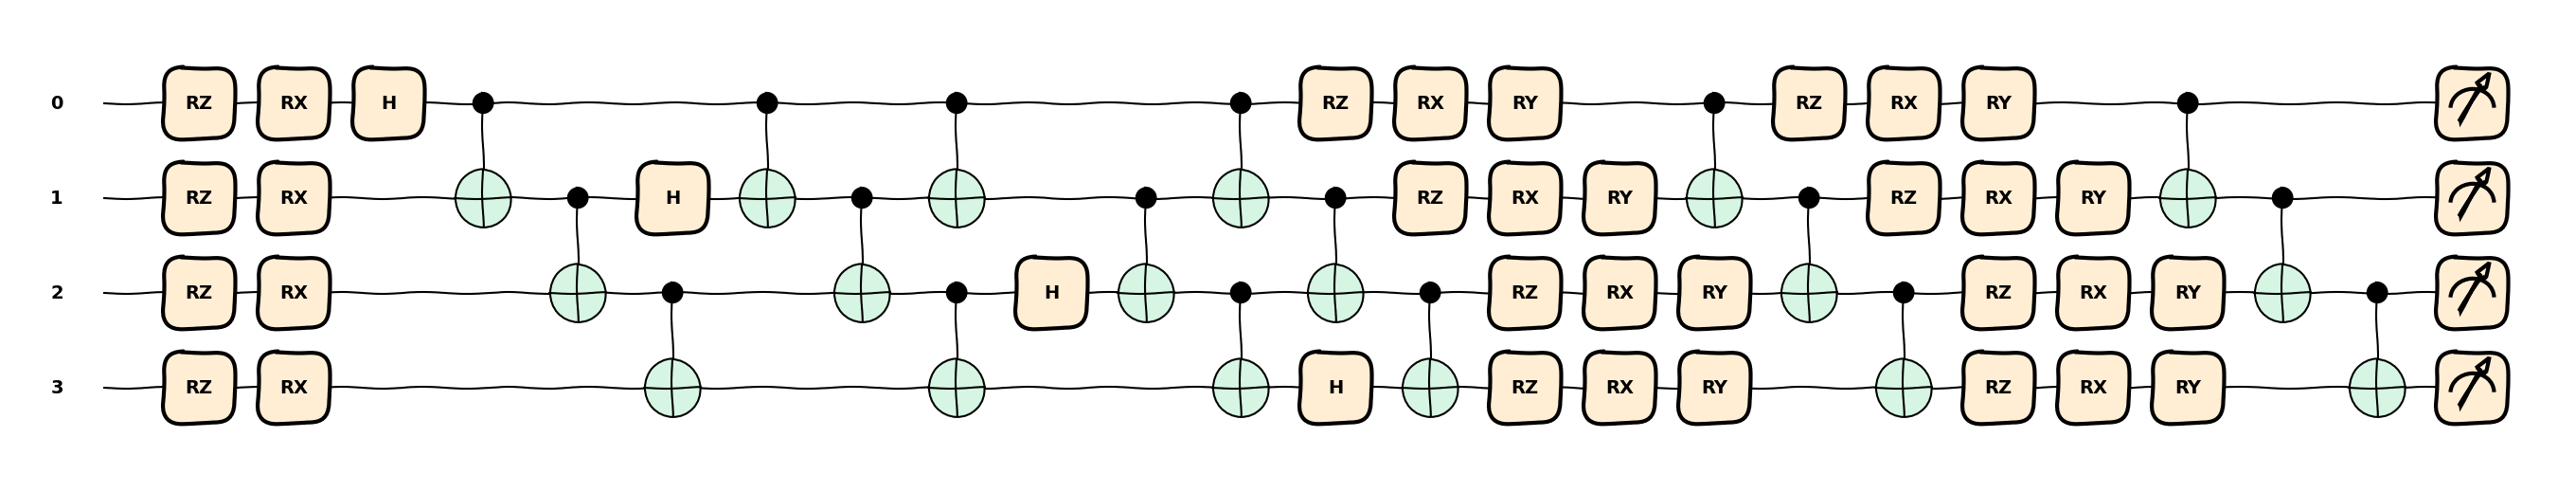

In [17]:
batch_size = 2
inputs = np.random.random((batch_size, qubits))
weights = np.random.random((layers_sayisi, qubits, 3))

qml.drawer.use_style("sketch")
fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
plt.show()

## Klasik ve kuantum makine öğrenme modelinin hazırlanması

In [18]:
def hibritModel(image_size=(64, 64)):

    model = models.Sequential([
        # keras için giriş katmanını temsil ediyor.
        layers.Input(shape=(*image_size, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        #klasik verilerin kuantum katmanına uygun olması için aşağıdaki kod eklenmiştir. kullandığımz qubit sayısı 4 olduğu için çıkış 4 uzunluğunda bir vektör olacaktır.
        layers.Dense(qubits)
    ])

    # qml.qnn: klasik model ile kuantum model arasında işlevsellik sağlayan pennylane modülüdür. Pennylane bunu kuantum devresindeki öğrenilebilir parametrelerin şeklini belirten sözlük olarak tanımlar.
    quantum_layer = qml.qnn.KerasLayer(
        quantum_circuit,
        # Buradaki weights tensörü dönüş kapılarının parametrelerini temsil edecektir.
        weight_shapes={"weights": (layers_sayisi, qubits, 3)},
        output_dim=qubits,
        dtype=tf.float32
    )


    outputs = layers.Dense(3, activation="softmax")(quantum_layer(model.output))

    hibrit_model = tf.keras.Model(inputs=model.input, outputs=outputs)

    return hibrit_model

In [19]:
from tensorflow.keras.utils import plot_model


model = hibritModel(image_size=(64, 64))


plot_model(model, show_shapes=True, show_layer_names=True)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928 

In [20]:
def compile_and_train_model(train_ds, epochs):
    model = hibritModel()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_data,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=3,
            restore_best_weights=True
        )]
    )

    return model, history

def main():
    tf.get_logger().setLevel('ERROR')

    train_ds, test_ds = train_data, test_data

    model, history = compile_and_train_model(train_ds, epochs=20)

    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test doğruluğu: {test_acc}")

    return model, history, test_ds

if __name__ == "__main__":
    model, history, test_ds = main()


Epoch 1/20
18/18 [==============================] - 8s 448ms/step - loss: 1.0346 - accuracy: 0.5248 - val_loss: 0.9142 - val_accuracy: 0.6901
Epoch 2/20
18/18 [==============================] - 9s 514ms/step - loss: 0.9332 - accuracy: 0.6418 - val_loss: 0.8899 - val_accuracy: 0.6901
Epoch 3/20
18/18 [==============================] - 8s 463ms/step - loss: 0.8743 - accuracy: 0.6702 - val_loss: 0.8170 - val_accuracy: 0.7042
Epoch 4/20
18/18 [==============================] - 9s 483ms/step - loss: 0.7369 - accuracy: 0.8511 - val_loss: 0.6641 - val_accuracy: 0.9577
Epoch 5/20
18/18 [==============================] - 8s 437ms/step - loss: 0.6143 - accuracy: 0.9770 - val_loss: 0.5765 - val_accuracy: 0.9718
Epoch 6/20
18/18 [==============================] - 8s 450ms/step - loss: 0.5418 - accuracy: 0.9823 - val_loss: 0.5217 - val_accuracy: 0.9718
Epoch 7/20
18/18 [==============================] - 8s 459ms/step - loss: 0.4917 - accuracy: 0.9858 - val_loss: 0.4746 - val_accuracy: 0.9718
Epoch 

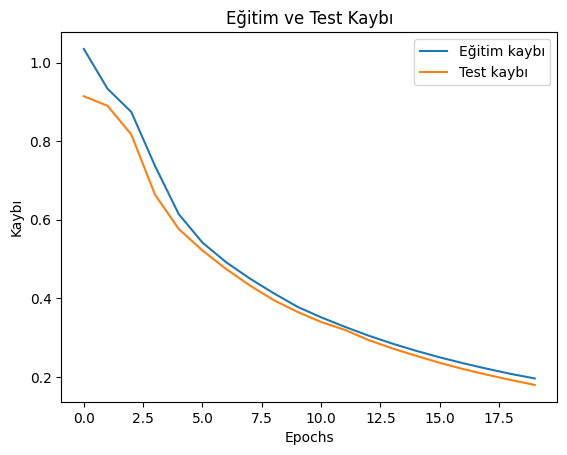

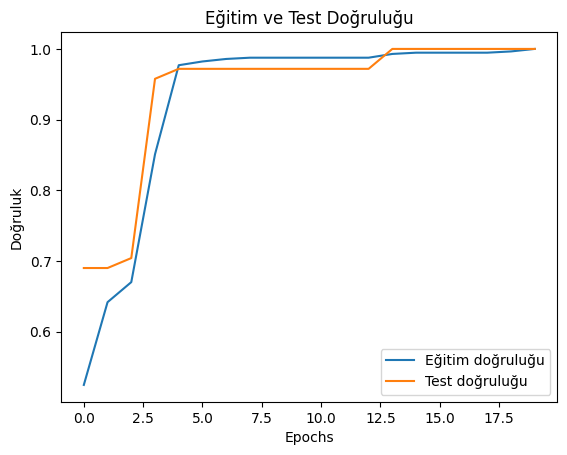

In [21]:
def kayip_fonk(history):
    plt.plot(history.history['loss'], label='Eğitim kaybı')
    plt.plot(history.history['val_loss'], label='Test kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epochs')
    plt.ylabel('Kaybı')
    plt.legend()
    plt.show()


def dogruluk_fonk(history):
    plt.plot(history.history['accuracy'], label='Eğitim doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Test doğruluğu')
    plt.title('Eğitim ve Test Doğruluğu')
    plt.xlabel('Epochs')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.show()
kayip_fonk(history)
dogruluk_fonk(history)

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def tahminler(model, dataset):
    gercek = []
    tahmin = []

    for images, labels in dataset:
        predictions = model.predict(images)

        gercek.extend(labels.numpy())
        tahmin.extend(np.argmax(predictions, axis=1))


    return np.array(gercek), np.array(tahmin)

def confusionMatris(gercek, tahmin, sinif):
    cm = confusion_matrix(gercek, tahmin)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=sinif_isimleri, yticklabels=sinif_isimleri)
    plt.title("Confusion Matrix")
    plt.xlabel("Tahminler")
    plt.ylabel("Gercek")
    plt.show()

train_g, train_tahmin = tahminler(model, train_data)
test_g, test_tahmin = tahminler(model, test_data)

1/1 [==============================] - 0s 121ms/step


EĞİTİM VERİSİ İÇİN


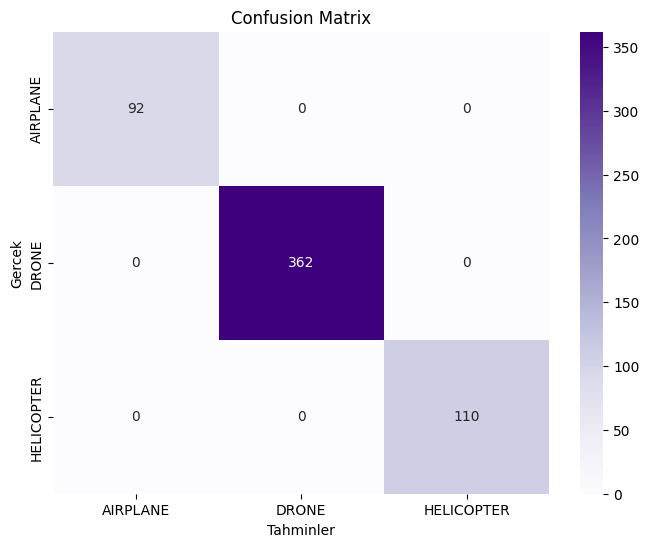

In [23]:
print("EĞİTİM VERİSİ İÇİN")
confusionMatris(train_g,train_tahmin,sinif_isimleri)

TEST VERİSİ İÇİN :


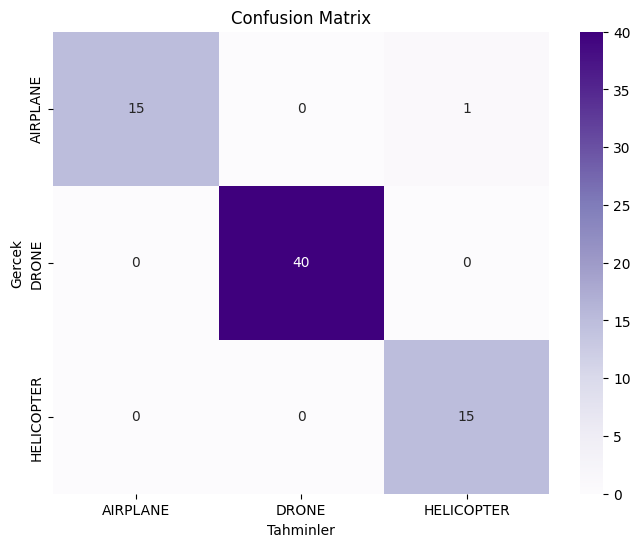

In [24]:
print("TEST VERİSİ İÇİN :")
confusionMatris(test_g, test_tahmin, sinif_isimleri)